<a href="https://colab.research.google.com/github/msandeep27/Kaggle-Aerial-Cactus-Identification/blob/master/aerial_cactus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
import os
import gzip
import io

In [0]:
print(os.listdir("../input"))

['keras-pretrained-models', 'aerial-cactus-identification']


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import cv2
from tqdm import tqdm, tqdm_notebook


In [0]:
train=pd.read_csv("../input/aerial-cactus-identification/train.csv")
train.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [0]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.preprocessing.image as image
import IPython.display as display
import matplotlib.image as mping;
import scipy.ndimage
from sklearn.metrics import confusion_matrix

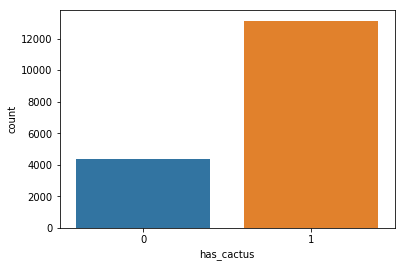

In [0]:
defaultTrainPath='../input/aerial-cactus-identification/train/train/'
defaultTestPath='../input/aerial-cactus-identification/test/test/'

sns.countplot(x='has_cactus',data=train)

In [0]:
train.shape

(17500, 2)

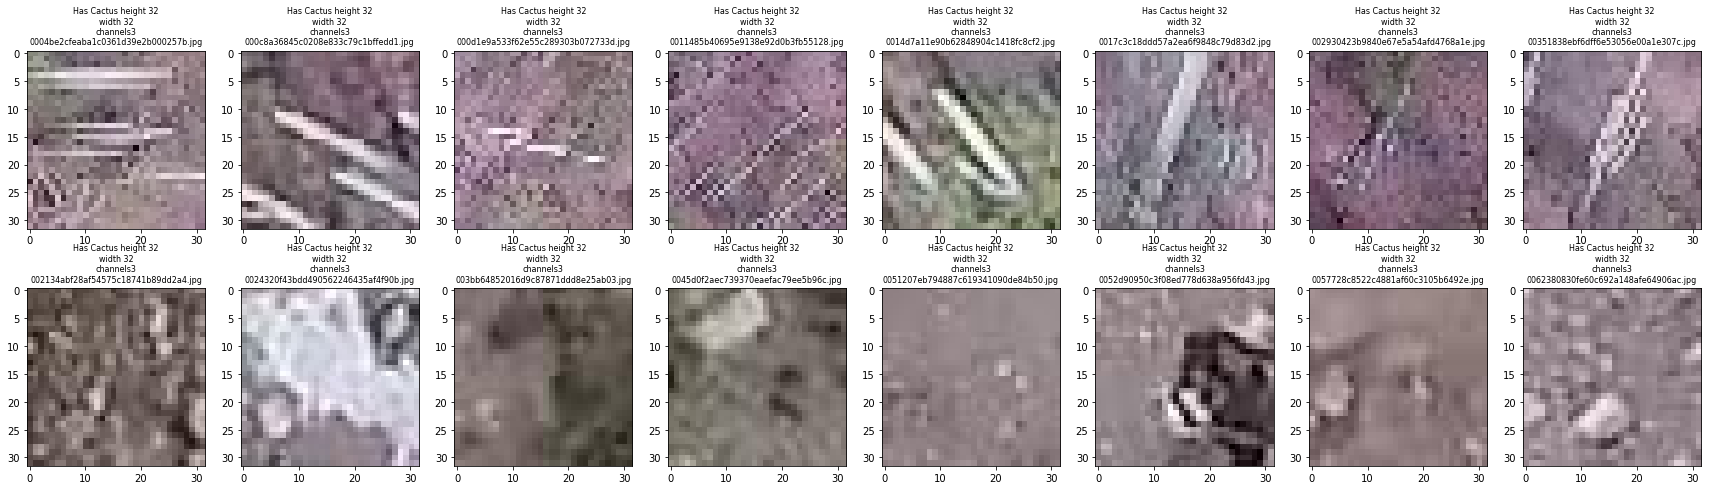

In [0]:
fig, axarr = plt.subplots(2, 8, figsize=(30, 8))
cactus_count=0;
no_cactus=0;
  
for i,row in train[:1000].iterrows():
  if((row['has_cactus']==1) & (cactus_count<=7)):
    img1=imageio.imread(defaultTrainPath+row['id'])
    axarr[0,cactus_count].imshow(img1,cmap=plt.cm.gray)
    height, width, channels = img1.shape
    axarr[0,cactus_count].set_title("Has Cactus height "+str(height) +"\nwidth "+str(width) +"\nchannels"+str(channels)+"\n"+str(row['id']), fontsize=8)
   # print(row['id'])
    cactus_count=cactus_count+1;
  elif ((row['has_cactus']==0) & (no_cactus<=7)):
    img1=imageio.imread(defaultTrainPath+row['id'])
    axarr[1,no_cactus].imshow(img1)
    height, width, channels = img1.shape
   # print(row['id'])

    axarr[1,no_cactus].set_title("Has Cactus height "+str(height) +"\nwidth "+str(width) +"\nchannels"+str(channels)+"\n"+str(row['id']), fontsize=8)
    no_cactus=no_cactus+1;

In [0]:
from tensorflow.keras.applications import resnet50,vgg16
#from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
train['has_cactus']=train.has_cactus.astype('str')

In [0]:
train.shape

(17500, 2)

In [0]:
Image_Shape=imageio.imread(defaultTrainPath+train.id[0]).shape
print(Image_Shape)

(32, 32, 3)


In [0]:
datagen=ImageDataGenerator(rescale=(1./255))
                         #  zoom_range=0.3,
                          # validation_split=0.10)

In [0]:
train_generator=datagen.flow_from_dataframe(train, directory=defaultTrainPath, x_col='id', y_col='has_cactus',subset="training",target_size=(32, 32), color_mode='rgb', class_mode='binary', batch_size=32, shuffle=True, seed=1);

Found 17500 validated image filenames belonging to 2 classes.


In [0]:
valid_generator=datagen.flow_from_dataframe(train, directory=defaultTrainPath, x_col='id', y_col='has_cactus',subset="validation",target_size=(32, 32), color_mode='rgb', class_mode='binary', batch_size=32, shuffle=True, seed=1);

Found 0 validated image filenames belonging to 2 classes.


In [0]:
base_model=tf.keras.applications.vgg16.VGG16(input_shape=(Image_Shape),
                                               include_top=False,
                                               pooling='max',
                                                weights='../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

base_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [0]:
base_model.trainable = False
# Fine tune from this layer onwards
fine_tune_at = 2

# Freeze all the layers before the `fine_tune_at` layer
#for layer in base_model.layers[:fine_tune_at]:
#  layer.trainable =  False
  
base_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [0]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  20


In [0]:
model = tf.keras.Sequential([
  base_model,
  #tf.keras.layers.GlobalAveragePooling2D(),
  #tf.keras.layers.Flatten(),
 # tf.keras.layers.Dropout(0.4),
 # tf.keras.layers.Dense(128),
  #tf.keras.layers.Activation('relu'),
  tf.keras.layers.Flatten(),
  #tf.keras.layers.Dropout(0.2),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.2),
  #tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Activation('sigmoid')
])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total para

In [0]:
len(model.trainable_variables)

4

In [0]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
es = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1)
]

mcp = [
    keras.callbacks.ModelCheckpoint(
        filepath='mymodel_{epoch}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

In [0]:
%%time

#STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
#print(" Train size {} Test Size {}",STEP_SIZE_TRAIN,STEP_SIZE_VALID)
#hist=model.fit_generator(generator=train_generator,
#                    steps_per_epoch=STEP_SIZE_TRAIN,
#                    validation_data=valid_generator,
#                    validation_steps=STEP_SIZE_VALID,
#                    epochs=400,
#                    callbacks=es
#)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 23.6 µs


In [0]:
print("Number of layers in the base model: ", len(model.layers))


Number of layers in the base model:  7


In [0]:
X_tr = []
Y_tr = []
imges = train['id'].values
for img_id in tqdm_notebook(imges):
    X_tr.append(cv2.imread(defaultTrainPath + img_id))    
    Y_tr.append(train[train['id'] == img_id]['has_cactus'].values[0])  
X_tr = np.asarray(X_tr)
X_tr = X_tr.astype('float32')
X_tr /= 255
Y_tr = np.asarray(Y_tr)

In [0]:
%%time
batch_size = 32
nb_epoch = 40

# Train model
history = model.fit(X_tr, Y_tr,
              batch_size=batch_size,
              epochs=nb_epoch,
              validation_split=0.1,
              shuffle=True,
              verbose=2
             # callbacks=es
              )

Train on 15750 samples, validate on 1750 samples
Epoch 1/40
 - 8s - loss: 0.3435 - acc: 0.8509 - val_loss: 0.1989 - val_acc: 0.9469
Epoch 2/40
 - 4s - loss: 0.1829 - acc: 0.9353 - val_loss: 0.1474 - val_acc: 0.9566
Epoch 3/40
 - 4s - loss: 0.1468 - acc: 0.9474 - val_loss: 0.1274 - val_acc: 0.9554
Epoch 4/40
 - 4s - loss: 0.1321 - acc: 0.9524 - val_loss: 0.1156 - val_acc: 0.9611
Epoch 5/40
 - 4s - loss: 0.1209 - acc: 0.9555 - val_loss: 0.1097 - val_acc: 0.9611
Epoch 6/40
 - 4s - loss: 0.1138 - acc: 0.9583 - val_loss: 0.1017 - val_acc: 0.9623
Epoch 7/40
 - 4s - loss: 0.1068 - acc: 0.9613 - val_loss: 0.0986 - val_acc: 0.9657
Epoch 8/40
 - 4s - loss: 0.1025 - acc: 0.9613 - val_loss: 0.0939 - val_acc: 0.9646
Epoch 9/40
 - 4s - loss: 0.0997 - acc: 0.9637 - val_loss: 0.0901 - val_acc: 0.9657
Epoch 10/40
 - 4s - loss: 0.0963 - acc: 0.9637 - val_loss: 0.0876 - val_acc: 0.9657
Epoch 11/40
 - 4s - loss: 0.0931 - acc: 0.9668 - val_loss: 0.0856 - val_acc: 0.9669
Epoch 12/40
 - 4s - loss: 0.0899 - a

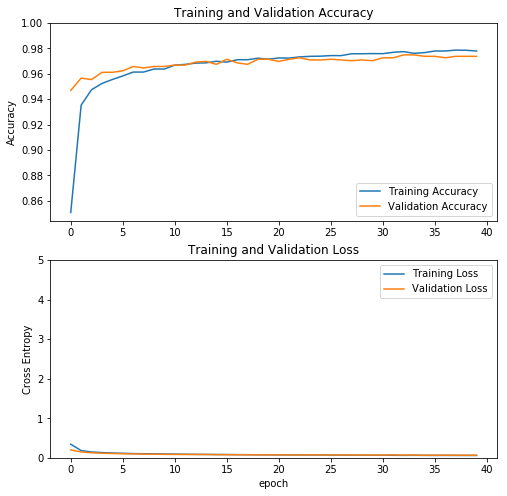

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
%%time
X_tst = []
Test_imgs = []
for img_id in tqdm_notebook(os.listdir(defaultTestPath)):
    X_tst.append(cv2.imread(defaultTestPath + img_id))     
    Test_imgs.append(img_id)
X_tst = np.asarray(X_tst)
X_tst = X_tst.astype('float32')
X_tst /= 255



CPU times: user 964 ms, sys: 944 ms, total: 1.91 s
Wall time: 8.92 s


In [0]:
# Prediction
test_predictions = model.predict(X_tst)

sub_df = pd.DataFrame(test_predictions, columns=['has_cactus'])
sub_df['has_cactus'] = sub_df['has_cactus'].apply(lambda x: 1 if x > 0.75 else 0)

sub_df['id'] = ''
cols = sub_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
sub_df=sub_df[cols]

for i, img in enumerate(Test_imgs):
    sub_df.set_value(i,'id',img)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


In [0]:
sub_df.head()

,id,has_cactus
0,9cdda32671cb192f096b20c91b46a150.jpg,1
1,da498fc860c8b76ca925c4218c5f0373.jpg,0
2,433052030eeb117e4bd8f6ce033c9da4.jpg,1
3,4c76899a6e4b4a6cfdd2f28707fa8114.jpg,0
4,9efa3e92c1475b3ce4b7e2e598fa2785.jpg,1


In [0]:
sub_df.to_csv('submission.csv',index = False)